# Assignment 3 by: Rakshit Chandna (s3956924)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from surprise import SVD, Dataset, Reader, accuracy
from sklearn.metrics import average_precision_score, ndcg_score

In [2]:
# Load the ratings dataset
names = ['user_id', 'item_id', 'rating', 'timestamp']
movie_ratings_df = pd.read_csv('./ml-1m/ratings.dat', sep='::',engine='python', names=names)
print(movie_ratings_df.head())

   user_id  item_id  rating  timestamp
0        1     1193       5  978300760
1        1      661       3  978302109
2        1      914       3  978301968
3        1     3408       4  978300275
4        1     2355       5  978824291


In [3]:
# Checking the data types of all variables 
movie_ratings_df.dtypes

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

In [4]:
# Checking missing values
movie_ratings_df.isna().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

In [5]:
# Assigning names as colnames by putting a sepearator 
i_cols = ['MovieID','Title','Genres']
items = pd.read_csv('./ml-1m/movies.dat', sep='::',engine='python', names=i_cols, encoding='latin-1')
items.head(10)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [6]:
# Check on the shape of the dataset
n_users = movie_ratings_df.user_id.unique().shape[0]
n_items = movie_ratings_df.item_id.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' items')

6040 users
3706 items


In [7]:
# Splitting the dataset into training and testing with 80% training and 20% testing
train_df, test_df = train_test_split(movie_ratings_df, test_size=0.2)
train_df, test_df

(        user_id  item_id  rating  timestamp
 987170     5958     1259       4  957063323
 155739     1004     1479       3  975041413
 891661     5387     1959       2  961191981
 785126     4687     1270       4  963620840
 993604     6001     1519       3  964030592
 ...         ...      ...     ...        ...
 740568     4425     1562       3  965112510
 221741     1340     2028       4  974778633
 899170     5434      933       5  960045731
 263713     1605     1047       4  975381153
 638228     3841     3118       3  965999246
 
 [800167 rows x 4 columns],
         user_id  item_id  rating  timestamp
 183798     1145      858       1  974873157
 29986       202     2699       3  976939275
 361232     2106      569       2  975130533
 742102     4436      233       4  965101086
 514153     3173       24       4  968791764
 ...         ...      ...     ...        ...
 296417     1758     1104       4  974784545
 861955     5185     2067       3  963403884
 627009     3792      173

In [8]:
# Selecting the Maximum values of the Training and Testing set
max_train_item = train_df['item_id'].max()
max_test_item = test_df['item_id'].max()

print(f"Max item_id in training set: {max_train_item}")
print(f"Max item_id in testing set: {max_test_item}")

max_item = max(max_train_item, max_test_item)

if max_item > n_items:
    n_items = max_item


Max item_id in training set: 3952
Max item_id in testing set: 3952


In [9]:
# Finding the maximum user and item indices in your dataset
max_user_id = max(train_df['user_id'].max(), test_df['user_id'].max())
max_item_id = max(train_df['item_id'].max(), test_df['item_id'].max())

# Creating empty NumPy arrays for training and testing datasets based on the maximum indices
train_ds = np.zeros((max_user_id, max_item_id))
test_ds = np.zeros((max_user_id, max_item_id))

# Filling the training dataset
for row in train_df.itertuples():
    user_idx = row[1] - 1
    item_idx = row[2] - 1
    rating = row[3] if row[3] >= 0 else 0.00
    train_ds[user_idx, item_idx] = rating

# Filling the testing dataset
for row in test_df.itertuples():
    user_idx = row[1] - 1
    item_idx = row[2] - 1
    rating = row[3] if row[3] >= 0 else 0.00
    test_ds[user_idx, item_idx] = rating


# Converting the NumPy arrays to pandas DataFrames
train_ds = pd.DataFrame(train_ds)
test_ds = pd.DataFrame(test_ds)

# Displaying the first few rows of the train_ds and test_ds DataFrames
print("Training Dataset:")
print(train_ds)

print("\nTesting Dataset:")
print(test_ds)


Training Dataset:
      0     1     2     3     4     5     6     7     8     9     ...  3942  \
0      5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
6035   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6036   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6037   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6038   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6039   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      3943  3944  3945  3946  394

## Task 1: User-based Collaborative Filtering

# Fitting the Algorithm
## User-based
### Compute Pearson Correlation Coefficient for a Random User in Training Dataset

In [10]:
# Setting the active_user_id, which represents the user for whom we want to make movie recommendations
active_user_id = 1010

# Defining the user_movie_matrix by pivoting the movie_ratings_df DataFrame to create a user-item matrix
# It fills missing values with 0 to represent unrated movies
user_movie_matrix = movie_ratings_df.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Getting the index (row) in the user_movie_matrix corresponding to the active_user_id
active_user_index = user_movie_matrix.index.get_loc(active_user_id)

# Computing the cosine similarity between all pairs of users, resulting in a user-user similarity matrix
np_user_pearson_corr = cosine_similarity(user_movie_matrix)

# Creating an empty array to store predicted ratings for the active user
# n_users and n_items are assumed to be defined elsewhere in the code
np_predictions = np.zeros((n_users, n_items))

# Creating an empty list to store results (K, RMSE) for different values of K
results = []

# Defining a range of values for K (number of similar users to consider)
K_values = range(25, 251, 25)

# Defining a small constant EPSILON to prevent division by zero
EPSILON = 1e-9

# Iterating over each value of K.
for K in K_values:
    # Finding the indices of the K most similar users to the active user based on Pearson correlation.
    sim_user_ids = np.argsort(np_user_pearson_corr[active_user_index])[-(K + 1):-1]
    sim_val = np_user_pearson_corr[active_user_index][sim_user_ids]

    # Getting the ratings of the active user.
    active_user_ratings = user_movie_matrix.iloc[active_user_index].values

    # Calculating the mean rating of the active user, avoiding division by zero
    user_mean = np.sum(active_user_ratings) / (np.sum(np.clip(active_user_ratings, 0, 1)) + EPSILON)
    
    # Getting the ratings of the K most similar users
    sim_users = user_movie_matrix.iloc[sim_user_ids].values
    
    # Calculating the mean ratings of the K most similar users, avoiding division by zero
    sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

    # Initializing an empty list to store squared errors for each movie
    squared_errors = []

    # Iterating over each movie (item) in the user_movie_matrix
    for j in range(user_movie_matrix.shape[1]):
        # Creating a mask for movies that have been rated by the similar users
        mask_rated_j = sim_users[:, j] > 0
        
        # Calculating the weighted sum of differences between similar users' ratings and their mean
        sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])
        
        # Calculating the predicted rating for the current movie for the active user
        predicted_ratings = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
        
        # Assigning the predicted rating to be within the range [0, 5]
        predicted_ratings = np.clip(predicted_ratings, 0, 5)
        
        # Estimating the squared error for the predicted rating compared to the actual rating
        squared_error = np.square(predicted_ratings - active_user_ratings[j])
        
        # Applying a weight to the squared error to consider only rated movies
        weight = np.clip(active_user_ratings[j], 0, 1)
        squared_errors.append(squared_error * weight)

    # Estimating the Root Mean Square Error (RMSE) for the active user and this value of K
    RMSE = np.sqrt(np.sum(squared_errors) / np.sum(np.clip(active_user_ratings, 0, 1)))
    
    # Storing the results (K, RMSE) in the results list
    results.append((K, RMSE))

# Printing the RMSE values for different values of K
print("RMSE value for different random values of K:")
for K, RMSE in results:
    print(f"K: {K}, RMSE: {RMSE}")


RMSE value for different random values of K:
K: 25, RMSE: 0.9204745597121166
K: 50, RMSE: 0.9062654531467716
K: 75, RMSE: 0.9057443692944694
K: 100, RMSE: 0.9114137035999965
K: 125, RMSE: 0.913938959455114
K: 150, RMSE: 0.9162682745594402
K: 175, RMSE: 0.9176467271337998
K: 200, RMSE: 0.9179432820784139
K: 225, RMSE: 0.9171509543128872
K: 250, RMSE: 0.9167505662140943


In [11]:
# Assigning the value of K as 75 due to least RMSE score
k = 75  

# Iterating through for loop in the columns (movies) of the test dataset
for j, rating in enumerate(test_ds.columns):
    if rating > 0:
        # Finding the indices of K most similar users to the active user based on Pearson correlation
        sim_user_ids = np.argsort(np_user_pearson_corr[active_user_index])[-(K + 1):-1]
        
        # Retrieving the Pearson correlation values for the similar users
        sim_val = np_user_pearson_corr[active_user_index][sim_user_ids]
        
        # Getting the corresponding user data for the similar users from the training dataset
        sim_users = train_ds.values[sim_user_ids]
        
        # Estimating the mean rating of the active user
        user_mean = np.sum(train_ds.values[active_user_index]) / (np.sum(np.clip(train_ds.values[active_user_index], 0, 1)) + EPSILON)
        
        # Calculating the mean rating for each of the similar users
        sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)
        
        # Creating a mask to filter out similar users who have not rated the current movie (rating > 0)
        mask_rated_j = sim_users[:, j] > 0
        
        # Estimating the sum of similarity values weighted by the difference between each user's rating
        # for the current movie and their mean rating
        sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])
        
        # Predicting the rating for the active user for the current movie
        np_predictions[active_user_index][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
        
        # Assigning the predicted rating to be within the range [0, 5]
        np_predictions[active_user_index][j] = np.clip(np_predictions[active_user_index][j], 0, 5)

# Extracting the predicted ratings for the active user
predicted_ratings = np_predictions[active_user_index]

# Creating a DataFrame to store the MovieID and PredictedRating
predicted_ratings_df = pd.DataFrame({'MovieID': test_ds.columns, 'PredictedRating': predicted_ratings})

# Merging the MovieID and PredictedRating with the movie titles from the 'items' DataFrame
predicted_ratings_with_titles = predicted_ratings_df.merge(items, on='MovieID')

# Sorting the DataFrame by PredictedRating in descending order
predicted_ratings_sorted = predicted_ratings_with_titles.sort_values(by='PredictedRating', ascending=False)

# Specifing the number of top movies to recommend to the user
top_N_movies = 3705

# Selecting the top N movies with the highest predicted ratings
top_movies = predicted_ratings_sorted.head(top_N_movies)

# Printing the top-rated movies for the active user by id
print("Top Movies Rated by the User with ID", active_user_id)
print(top_movies[['Title', 'PredictedRating']])


Top Movies Rated by the User with ID 1010
                                         Title  PredictedRating
1059   Sexual Life of the Belgians, The (1994)         4.505132
567                   Wedding Gift, The (1994)         4.469082
3268  I'll Never Forget What's 'is Name (1967)         4.186999
961                       Meet John Doe (1941)         4.172331
947                    Of Human Bondage (1934)         3.981965
...                                        ...              ...
2043                       Grand Canyon (1991)         1.062943
287                  Once Were Warriors (1994)         1.060720
1793                         Species II (1998)         1.048731
2466                         Earthquake (1974)         1.047795
2195                    We're No Angels (1989)         1.044592

[3705 rows x 2 columns]


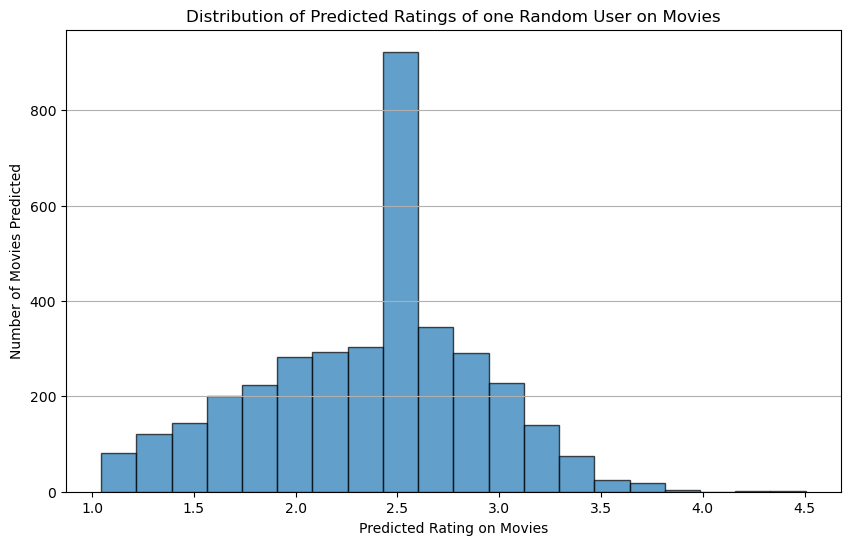

In [12]:
# Creating a Histogram plot to visualise the User-based collaborative filtering
plt.figure(figsize=(10,6))
plt.hist(top_movies['PredictedRating'], bins=20, edgecolor="k", alpha=0.7)   # Predicted rating is been plotted on bars
plt.title("Distribution of Predicted Ratings of one Random User on Movies")
plt.xlabel("Predicted Rating on Movies")
plt.ylabel("Number of Movies Predicted")
plt.grid(axis='y')
plt.show()


# Taks 2: Item-based Filtering

In [13]:
# Defining a function to predict movie ratings using Pearson correlation 
def predict_movie_ratings(train_ds, np_item_pearson_corr, movie_index, K=125, EPSILON=1e-9):
    user_predictions = []  # A list to store user predictions and RMSE later

    # Calculating the similarity scores between the target movie (movie_index) and all other movies
    sim_item_ids = np.argsort(np_item_pearson_corr[movie_index])[-(K + 1):-1]
    sim_val = np_item_pearson_corr[movie_index][sim_item_ids]

    # Looping through each user in the training dataset
    for user_index in range(train_ds.shape[0]):
        sim_items = train_ds.T.values[sim_item_ids, user_index]

        # Estimating the mean rating for items that the user has rated
        item_mean = np.sum(sim_items) / (np.sum(np.clip(sim_items, 0, 1)) + EPSILON)
        sim_item_mean = np.sum(sim_items) / (np.sum(np.clip(sim_items, 0, 1)) + EPSILON)

        # Calculate the weighted sum of (similarity * (rating - item_mean))
        sim_r_sum_mean = sim_val * (sim_items - sim_item_mean)

        # Applying a binary clip to sim_items
        w = np.clip(sim_items, 0, 1)
        sim_r_sum_mean *= w

        # Calculate the user's predicted rating for the target movie
        user_prediction = item_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val * w) + EPSILON)
        user_prediction = np.clip(user_prediction, 0, 5)  # Clip the prediction to the range [0, 5]

        user_predictions.append((user_index, user_prediction))  # Store the user prediction

        labels = train_ds.values[user_index]  # Get the actual ratings given by the user

        # Calculating the squared error for each user's prediction and apply a binary clip to labels
        squared_error = np.square(user_prediction - labels)
        weight = np.clip(labels, 0, 1)

        squared_error = squared_error * weight  # Apply the weight to the squared error.

        RMSE = np.sqrt(np.sum(squared_error) / np.sum(weight))  # Calculate RMSE for this user.

    return user_predictions, RMSE

# Defining another function to get top similar movies for the random movie
def get_top_k_similar_movies(movie_id, K=10):
    movie_idx = test_ds.columns.get_loc(movie_id)
    # Get the indices of the top K similar movies to the given movie_id.
    top_k_movie_indices = np.argsort(item_similarity[movie_idx])[-(K+1):-1]  # Exclude the movie itself.
    return test_ds.columns[top_k_movie_indices]

# Assuming train_ds, items, and n_users are already defined somewhere in the code.
movie_index = 175
np_user_pearson_corr = np.zeros((n_users, n_users))  # Initialize a user-user similarity matrix.

# Calculate user predictions and RMSE for a specific movie (movie_index) using Pearson correlation.
user_predictions_pearson, RMSE_Pearson = predict_movie_ratings(train_ds, np_user_pearson_corr, movie_index)

random_movie_id = 175  # Choose a random movie ID.
movie_name = items.loc[movie_index, 'Title']  # Get the title of the selected movie.

# Print RMSE for the selected movie using Pearson correlation.
print(f"RMSE for Movie '{movie_name}' using Pearson Corr: {RMSE_Pearson}")
print("\n" + "="*125 + "\n")

# Calculating item-item similarity matrix using cosine similarity.
item_similarity = cosine_similarity(train_ds.T)
print('Shape of item-item similarity matrix:', item_similarity.shape)

# Getting the top 10 similar movies to the randomly selected movie (random_movie_id).
top_k_similar_movies = get_top_k_similar_movies(random_movie_id, K=10)
print('Top 10 similar movies to movie ID', random_movie_id, 'are:', top_k_similar_movies)
print("\n" + "="*125 + "\n")

# Printing predicted ratings of users for the randomly selected movie.
print(f"\nPredicted Ratings of Users for Randomly Selected Movie -", movie_name, "with (ID: {}):".format(random_movie_id))
for user_index, prediction in user_predictions_pearson:
    print(f"User ID: {user_index} | Predicted Rating: {prediction:.2f}")


RMSE for Movie 'Lord of Illusions (1995)' using Pearson Corr: 1.1961210882545088


Shape of item-item similarity matrix: (3952, 3952)
Top 10 similar movies to movie ID 175 are: Index([1235, 347, 321, 1448, 561, 161, 1915, 2288, 573, 124], dtype='int64')



Predicted Ratings of Users for Randomly Selected Movie - Lord of Illusions (1995) with (ID: 175):
User ID: 0 | Predicted Rating: 4.50
User ID: 1 | Predicted Rating: 3.75
User ID: 2 | Predicted Rating: 0.00
User ID: 3 | Predicted Rating: 5.00
User ID: 4 | Predicted Rating: 2.67
User ID: 5 | Predicted Rating: 4.00
User ID: 6 | Predicted Rating: 5.00
User ID: 7 | Predicted Rating: 4.00
User ID: 8 | Predicted Rating: 4.25
User ID: 9 | Predicted Rating: 3.95
User ID: 10 | Predicted Rating: 4.33
User ID: 11 | Predicted Rating: 0.00
User ID: 12 | Predicted Rating: 3.40
User ID: 13 | Predicted Rating: 0.00
User ID: 14 | Predicted Rating: 3.75
User ID: 15 | Predicted Rating: 3.00
User ID: 16 | Predicted Rating: 4.09
User ID: 17 | Predicted Ra

C:\Users\Rakshit Chandna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Rakshit Chandna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


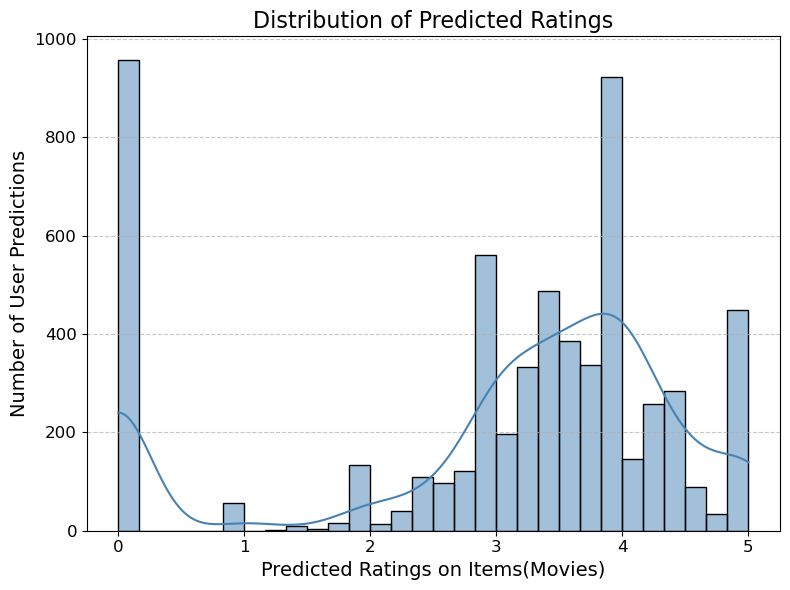

In [14]:
# Creating Histogram of the Item-based collaborative filtering
predicted_ratings = [pred[1] for pred in user_predictions_pearson]

plt.figure(figsize=(8, 6))
sns.histplot(predicted_ratings, bins=30, kde=True, color='steelblue')
plt.title('Distribution of Predicted Ratings', fontsize=16)
plt.xlabel('Predicted Ratings on Items(Movies)', fontsize=14)
plt.ylabel('Number of User Predictions', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Task 3: A Better Recommender System

## Task 3.1

##  Option1RecSys 

In [15]:
# Split the dataset into training and testing sets
# Here, `movie_ratings_df` is assumed to be a pandas DataFrame containing user ratings for movies
# The `test_size` parameter specifies the proportion of the dataset to include in the test split (20% in this case)
train_df, test_df = train_test_split(movie_ratings_df, test_size=0.2)

# Convert the training and testing DataFrames to Surprise datasets
# Surprise is a Python library for building and analyzing recommendation systems
# We use the `Reader` class to specify the rating scale, which is assumed to be from 1 to 5 in this case

# Creating a Reader object to specify the rating scale (1 to 5)
reader = Reader(rating_scale=(1, 5))

# Loading the training data into a Surprise Dataset object
train_data = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)

# Building a full training set from the training data
trainset = train_data.build_full_trainset()

# Loading the testing data into another Surprise Dataset object
test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)

# Building a test set from the training set (for evaluation)
testset = test_data.build_full_trainset().build_testset()

# Initializing the SVD (Singular Value Decomposition) model
# SVD is a matrix factorization technique commonly used in recommendation systems
model = SVD()

# Training the SVD model on the training data
model.fit(trainset)

# Making predictions using the trained model on the test set
predictions = model.test(testset)

# Estimating the Root Mean Squared Error (RMSE) to evaluate the model's performance
# RMSE measures the average error between predicted and actual ratings
rmse = accuracy.rmse(predictions)

# Printing the RMSE to assess the quality of the SVD model
print(f"Root Mean Squared Error (RMSE) of the SVD Model: {rmse}")


RMSE: 0.8763
Root Mean Squared Error (RMSE) of the SVD Model: 0.8763026311338035


## Task 3.2

## Recommend Top 30 movies for 5 Random users

In [16]:
# Defining a function to get recommendation from Matrix factorisation using SVD model
def get_recommendation_option1(user, model=model, n=10):
    
    # List to store the predictions
    predicted_ratings = []
    
    # Get all movie ids in the dataset
    all_movie_ids = movie_ratings_df['item_id'].unique()
    
    # Predicting ratings for all movies for the given user
    for movie_id in all_movie_ids:
        predicted_rating = model.predict(uid=user, iid=movie_id).est
        predicted_ratings.append((movie_id, predicted_rating))
        
    # Sorting the predictions based on the rating
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)
    
    # Getting the top-n movies' titles using the mapping dictionary
    recommended_movies_titles = [movie_id_to_title[x[0]] for x in predicted_ratings[:n]]
    
    return recommended_movies_titles

# Converting the "movie_id_to_title" as a dictionary to MovieID and Item [Title]
movie_id_to_title = dict(zip(items['MovieID'], items['Title']))


In [17]:
# Identifying users who have rated more than 100 movies
user_counts = movie_ratings_df['user_id'].value_counts()
eligible_users = user_counts[user_counts > 100].index.tolist()

# Randomly selecting 5 of these users
selected_users = np.random.choice(eligible_users, 5, replace=False)

# Recommending the Top-30 movies to each user using Option1RecSys
recommendations = {}
for user in selected_users:
    recommended_movies = get_recommendation_option1(user, n=30)
    recommendations[user] = recommended_movies

# Displaying the recommendations for each user
for user, movies in recommendations.items():
    print(f"\nRecommended movies for User ID {user}:\n{'-'*35}")
    for idx, movie in enumerate(movies, 1):
        print(f"{idx}. {movie}")



Recommended movies for User ID 2059:
-----------------------------------
1. Alien (1979)
2. Terminator, The (1984)
3. Godfather: Part II, The (1974)
4. Godfather, The (1972)
5. Blade Runner (1982)
6. Unforgiven (1992)
7. Outlaw Josey Wales, The (1976)
8. GoodFellas (1990)
9. Aliens (1986)
10. Exorcist, The (1973)
11. Good, The Bad and The Ugly, The (1966)
12. Close Encounters of the Third Kind (1977)
13. Jaws (1975)
14. To Kill a Mockingbird (1962)
15. Patton (1970)
16. Day the Earth Stood Still, The (1951)
17. This Is Spinal Tap (1984)
18. Stalag 17 (1953)
19. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
20. Die Hard (1988)
21. Wrong Trousers, The (1993)
22. Braveheart (1995)
23. Ben-Hur (1959)
24. Apocalypse Now (1979)
25. Mister Roberts (1955)
26. Star Wars: Episode IV - A New Hope (1977)
27. Mission, The (1986)
28. Animal House (1978)
29. Goldfinger (1964)
30. Deliverance (1972)

Recommended movies for User ID 1139:
----------------------------------

User 3978 - AP: 0.0796, NDCG: 0.5064
User 409 - AP: 0.1699, NDCG: 0.5977
User 3720 - AP: 0.0780, NDCG: 0.4893
User 2016 - AP: 0.0595, NDCG: 0.4583
User 5652 - AP: 0.2014, NDCG: 0.6055

Average AP over all users: 0.1177
Average NDCG over all users: 0.5314


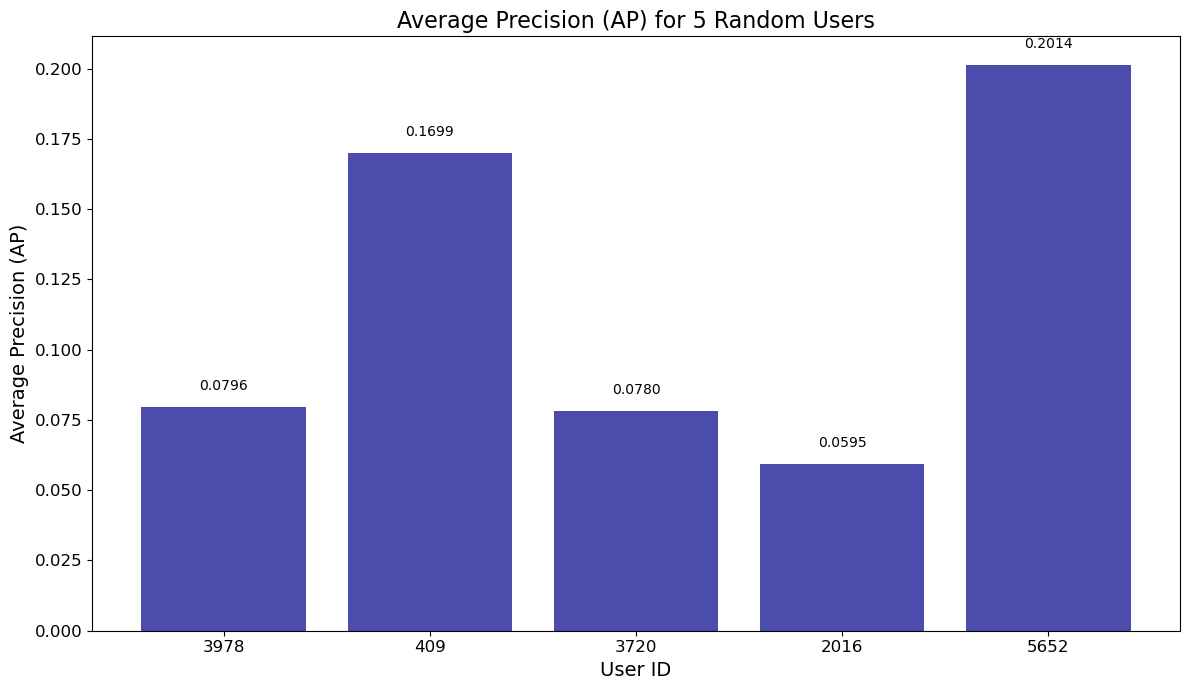

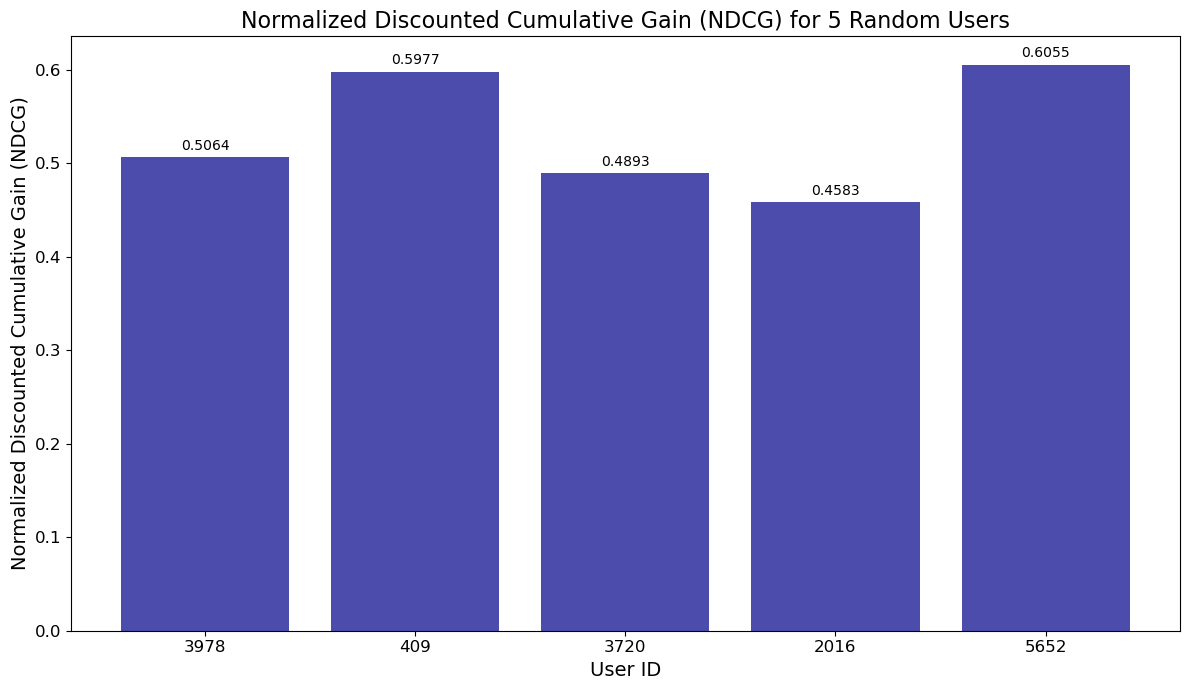

In [18]:
# Developing a Function to plot metrics
def plot_metrics(users, metrics, metric_name):
    # Creating a bar plot to visualize the metrics for selected users
    plt.figure(figsize=(12, 7))
    bars = plt.bar(np.arange(len(users)), metrics, color='darkblue', alpha=0.7)

    # Adding text labels above the bars with the metric values
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
                 f"{height:.4f}", ha='center', va='bottom', fontsize=10)

    # Setting x-axis labels as user IDs, and adjust font sizes and labels
    plt.xticks(np.arange(len(users)), users, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('User ID', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title(f"{metric_name} for 5 Random Users", fontsize=16)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Defining another function to visualise metrics 
def visualize_metrics(movie_ratings_df, model, selected_users):
    # Creating a mapping from movie_id to a continuous index
    movie_id_to_index = {movie_id: index for index, movie_id in enumerate(movie_ratings_df['item_id'].unique())}
    
    # Initialize lists to store binary relevance, predicted scores, average precision (AP), and NDCG values
    binary_relevance = []
    predicted_scores = []
    aps = []
    ndcgs = []

    # Iterating through a for loop for selected users
    for user in selected_users:
        # Initialize arrays to store relevance and predicted scores for each movie
        relevance = np.zeros(len(movie_ratings_df['item_id'].unique()))
        scores = np.zeros(len(movie_ratings_df['item_id'].unique()))
        
        # Getting the top-rated movies for the user and mark them as relevant
        top_movies = movie_ratings_df[movie_ratings_df['user_id'] == user].sort_values(by="rating", ascending=False)['item_id'].tolist()[:30]
        for movie in top_movies:
            relevance[movie_id_to_index[movie]] = 1
        
        # Predicting ratings for all movies for the user
        for movie_id in movie_ratings_df['item_id'].unique():
            scores[movie_id_to_index[movie_id]] = model.predict(uid=user, iid=movie_id).est
        
        # Append relevance and predicted scores to the respective lists
        binary_relevance.append(relevance)
        predicted_scores.append(scores)

        # Estimating Average Precision (AP) and Normalized Discounted Cumulative Gain (NDCG) for the user
        ap = average_precision_score(relevance, scores)
        nd = ndcg_score([relevance], [scores])

        # Append AP and NDCG values to their respective lists and print them for each user
        aps.append(ap)
        ndcgs.append(nd)
        print(f"User {user} - AP: {ap:.4f}, NDCG: {nd:.4f}")

    # Computing the average AP and NDCG values across all selected users
    avg_ap = np.mean(aps)
    avg_ndcg = np.mean(ndcgs)
    print(f"\nAverage AP over all users: {avg_ap:.4f}")
    print(f"Average NDCG over all users: {avg_ndcg:.4f}")
    
    # Plotting the metrics for selected users using the plot_metrics function
    plot_metrics(selected_users, aps, "Average Precision (AP)")
    plot_metrics(selected_users, ndcgs, "Normalized Discounted Cumulative Gain (NDCG)")

# Executing the visualization for a new random selection of users and their metrics
selected_users = np.random.choice(eligible_users, 5, replace=False)  # Choose your own eligible_users list
visualize_metrics(movie_ratings_df, model, selected_users)

## 3.2.1 MovieAvg

In [19]:
# Create a dictionary that maps movie IDs to their corresponding indices
# in the unique list of movie IDs in the 'item_id' column of movie_ratings_df
movie_id_to_index = {movie_id: index for index, movie_id in enumerate(movie_ratings_df['item_id'].unique())}

# Define a function to recommend movies based on average ratings
def movie_avg_recommendation(user, movie_ratings_df, num_recommendations=30):
    # Calculate average ratings for each movie and sort them in descending order
    avg_ratings = movie_ratings_df.groupby('item_id').rating.mean().sort_values(ascending=False)
    # Return the indices of the top-rated movies as a list of recommendations
    return avg_ratings.head(num_recommendations).index.tolist()

# Define a function to recommend movies randomly
def random_recommendation(user, movie_ratings_df, num_recommendations=30):
    # Return a random set of movie IDs from the unique list of movie IDs
    return np.random.choice(movie_ratings_df['item_id'].unique(), num_recommendations, replace=False)

# Define a function to compute Mean Average Precision (MAP) for a recommendation method
def compute_map_for_method(method, movie_ratings_df, model=None, num_recommendations=30):
    # Create an empty list to store Average Precision (AP) values for each user
    aps = []
    # Loop through selected users
    for user in selected_users:
        if method == 'model':
            # Using a model to get movie predictions (you would need to modify this based on your actual model)
            movie_ids = movie_ratings_df['item_id'].unique()
            # Get predicted ratings for all movies for the current user
            scores = np.array([model.predict(uid=user, iid=movie_id).est for movie_id in movie_ids])
            # Select the indices of the top-rated movies
            recommended_movie_indices = np.argsort(scores)[-num_recommendations:]
            # Get the recommended movie IDs based on their indices
            recommended_movies = [movie_ids[index] for index in recommended_movie_indices]

        elif method == 'movie_avg':
            # Get movie recommendations based on average ratings
            recommended_movies = movie_avg_recommendation(user, movie_ratings_df, num_recommendations)
        elif method == 'random':
            # Get random movie recommendations
            recommended_movies = random_recommendation(user, movie_ratings_df, num_recommendations)
        
        # Create a binary array to represent the relevance of each movie
        relevance = np.zeros(len(movie_ratings_df['item_id'].unique()))
        # Get the top-rated movies for the current user and mark them as relevant
        top_movies = movie_ratings_df[movie_ratings_df['user_id'] == user].sort_values(by="rating", ascending=False)['item_id'].tolist()[:num_recommendations]
        for movie in top_movies:
            relevance[movie_id_to_index[movie]] = 1

        # Create a binary array to represent the predicted recommendations
        predictions = np.zeros(len(movie_ratings_df['item_id'].unique()))
        # Mark the recommended movies as predicted
        for movie in recommended_movies:
            predictions[movie_id_to_index[movie]] = 1
            
        # Calculate Average Precision (AP) for the current user and add it to the list
        ap = average_precision_score(relevance, predictions)
        aps.append(ap)
        
    # Calculate the Mean Average Precision (MAP) by taking the mean of all AP values
    return np.mean(aps)

# Compute MAP for each recommendation method: Movie Average, Model, Random
map_movie_avg = compute_map_for_method('movie_avg', movie_ratings_df)
map_model = compute_map_for_method('model', movie_ratings_df, model=model)
map_random = compute_map_for_method('random', movie_ratings_df)

# Print the MAP values for each method
print(f"MAP for Movie Average: {map_movie_avg:.4f}")
print(f"MAP for Model: {map_model:.4f}")
print(f"MAP for Random Recommendation: {map_random:.4f}")

MAP for Movie Average: 0.0092
MAP for Model: 0.0434
MAP for Random Recommendation: 0.0083
